In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from tqdm import tqdm
from scipy.stats import pearsonr
from collections import defaultdict
import gseapy as gp
import anndata
import pandas as pd
from scipy import stats
from eval_utils import *
from plot_utils import *

from matplotlib.colors import LinearSegmentedColormap
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.formatters import decimal_to_percent
from plottable.plots import bar, percentile_bars, percentile_stars, progress_donut
import matplotlib

sns.set_style('whitegrid')

In [3]:
def discard_perts_not_in_var(adata):
    perturbations = adata.obs['condition'].str.split('+').str[0].values
    unique_perts = set(perturbations).difference(set(['ctrl']))
    discard_perts = [p for p in unique_perts if p not in adata.var['gene_name'].values]
    m = np.isin(perturbations, discard_perts)
    print(f'{100*sum(m) / len(m)}% of cells belong to perturbations not in gene panel... Warning: discarding them')
    adata = adata[~m]

    return adata

In [4]:
outdir = '../results'
figdir = f'{outdir}/overleaf/figures'
datasets = ['Adamson2016', 'Norman2019', 'ReplogleK562', 'ReplogleRPE1']
dataset_names = ['Adamson2016', 'Norman2019', 'Replogle_k562_2022', 'Replogle_rpe1_2022']
seeds = [1, 2, 3]
methods = ['cpa', 'gears', 'scgpt', 'scgpt_ft', 'nonctl-mean', 'matching-mean']

In [7]:
results_df = pd.DataFrame(
    columns=["dataset", "method", "pert", "seed", "corr_all", "corr_20de",
             "corr_all_allpert", "corr_20de_allpert",
             "mse_all", "mse_20de", "mse_all_allpert", "mse_20de_allpert",
             "jaccard", "jaccard_allpert", "one gene", "train"]
)
uns_dict = {}
avg_pert_centroids = 'centroids'
for dataset, dataset_name in zip(datasets, dataset_names):
    for seed in seeds:
        file = f'../data/{dataset_name.lower()}/{dataset_name.lower()}_{seed}.h5ad'
        adata = anndata.read_h5ad(file)
        adata = discard_perts_not_in_var(adata)
        print(dataset, len(adata.obs['condition'].unique()))
        
        # Compute differential expressed genes (for Jaccard similarity all pert. reference)
        if dataset not in uns_dict:
            adata_pert = adata[adata.obs['control'] == 0].copy()
            genes_dict = rank_genes_groups_allpert(adata_pert)
            adata.uns['rank_genes_groups_cov_allpert'] = genes_dict
            
            # Get non dropout top 20 DEG
            get_dropout_non_zero_genes_allpert(adata)
            uns = adata.uns.copy()
            uns_dict[dataset] = uns
    
        # Get control mean, non control mean (pert_mean), and non control mean differential
        train_adata = adata[adata.obs['split'] == 'train']
        control_adata = train_adata[train_adata.obs['control'] == 1]
        pert_adata = train_adata[train_adata.obs['control'] == 0]
        control_mean = np.array(control_adata.X.mean(axis=0))[0]
        # pert_mean = np.array(pert_adata.X.mean(axis=0))[0]
        if avg_pert_centroids == 'centroids':
            pert_mean = average_of_perturbation_centroids(pert_adata)
        elif avg_pert_centroids == 'two pert centroids':
            pert_mean = average_of_perturbation_centroids(pert_adata[~pert_adata.obs['condition'].str.contains('ctrl')])
        else:
            pert_mean = np.array(pert_adata.X.mean(axis=0))[0]
        
        for method in tqdm(methods):
            post_gt_df = pd.read_csv(f'{outdir}/{dataset}_{seed}_{method}_post-gt.csv', index_col=[0, 1])
            post_pred_df = pd.read_csv(f'{outdir}/{dataset}_{seed}_{method}_post-pred.csv', index_col=[0, 1])
            conditions = post_gt_df.index.get_level_values('condition').unique()
            for condition in conditions:
                gene_list = condition.split("+")
                one_gene = False
                if "ctrl" in gene_list:
                    gene_list.remove("ctrl")
                    one_gene = True
                one_gene_str = "1-gene" if one_gene else "2-gene"
    
                # Get data
                X_true = post_gt_df.loc[condition].values[0]
                X_pred = post_pred_df.loc[condition].values[0]
                delta_true = X_true - control_mean
                delta_pred = X_pred - control_mean

                delta_true_allpert = X_true - pert_mean
                delta_pred_allpert = X_pred - pert_mean
                n_train = post_gt_df.loc[condition].index.get_level_values('n_train').values[0]

                # Get top 20 DE genes
                adata_condition = adata[adata.obs["condition"] == condition]

                # Select top 20 DE genes
                top20_de_genes = adata.uns["top_non_dropout_de_20"][
                    adata_condition.obs["condition_name"].values[0]
                ]
                top20_de_idxs = np.argwhere(
                    np.isin(adata.var.index, top20_de_genes)
                ).ravel()

                top20_de_idxs_pred = get_topk_de_gene_ids(control_mean, X_pred, k=20)

                # Select top 20 DE genes (all pert)
                top20_de_genes_allpert = uns_dict[dataset]["top_non_dropout_de_20_allpert"][
                    adata_condition.obs["condition_name"].values[0]
                ]
                top20_de_idxs_allpert = np.argwhere(
                    np.isin(adata.var.index, top20_de_genes_allpert)
                ).ravel()
                top20_de_idxs_pred_allpert = get_topk_de_gene_ids(pert_mean, X_pred, k=20)

                # Store results
                results_df.loc[len(results_df)] = [
                    dataset,
                    method,
                    condition,
                    seed,
                    pearsonr(delta_true, delta_pred)[0],
                    pearsonr(delta_true[top20_de_idxs], delta_pred[top20_de_idxs])[0],
                    pearsonr(delta_true_allpert, delta_pred_allpert)[0],
                    pearsonr(delta_true_allpert[top20_de_idxs], delta_pred_allpert[top20_de_idxs])[0],
                    np.mean((delta_true - delta_pred)**2),
                    np.mean((delta_true[top20_de_idxs] - delta_pred[top20_de_idxs])**2),
                    np.mean((delta_true_allpert - delta_pred_allpert)**2),
                    np.mean((delta_true_allpert[top20_de_idxs] - delta_pred_allpert[top20_de_idxs])**2),
                    jaccard_similarity(top20_de_idxs, top20_de_idxs_pred),
                    jaccard_similarity(top20_de_idxs_allpert, top20_de_idxs_pred_allpert),
                    one_gene_str,
                    n_train,
                ]

0.0% of cells belong to perturbations not in gene panel... Warning: discarding them
Adamson2016 82


/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning:

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:411: PerformanceWarning: DataFram

100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.91it/s]


0.0% of cells belong to perturbations not in gene panel... Warning: discarding them
Adamson2016 82


100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.43it/s]


0.0% of cells belong to perturbations not in gene panel... Warning: discarding them
Adamson2016 82


100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.24it/s]


0.0% of cells belong to perturbations not in gene panel... Warning: discarding them
Norman2019 277


/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning:

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning:

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning:

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:411: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFr

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning:

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning:

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning:

/tmp/ipykernel_3006023/2181528860.py:20: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['rank_genes_groups_cov_allpert'] = genes_dict
100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.46s/it]


0.0% of cells belong to perturbations not in gene panel... Warning: discarding them
Norman2019 277


100%|█████████████████████████████████████████████| 6/6 [00:09<00:00,  1.54s/it]


0.0% of cells belong to perturbations not in gene panel... Warning: discarding them
Norman2019 277


100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.39s/it]


57.647029818916955% of cells belong to perturbations not in gene panel... Warning: discarding them
ReplogleK562 413


/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning:

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:411: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFr

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:411: PerformanceWarning: DataFram

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:411: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: PerformanceWarning: Da

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning:

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning:

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning:

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:411: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFr

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:411: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFr

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning:

/tmp/ipykernel_3006023/2181528860.py:20: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['rank_genes_groups_cov_allpert'] = genes_dict
100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.80s/it]


57.647029818916955% of cells belong to perturbations not in gene panel... Warning: discarding them
ReplogleK562 413


100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.71s/it]


57.647029818916955% of cells belong to perturbations not in gene panel... Warning: discarding them
ReplogleK562 413


100%|█████████████████████████████████████████████| 6/6 [00:09<00:00,  1.63s/it]


52.775626769419475% of cells belong to perturbations not in gene panel... Warning: discarding them
ReplogleRPE1 651


/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning:

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:411: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFr

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:411: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFr

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning:

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning:

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning:

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:411: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: PerformanceWarning: Da

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:411: PerformanceWarning: DataFram

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning:

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning:

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:411: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: PerformanceWarning: Da

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning:

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning:

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning:

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning:

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning:

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:411: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: PerformanceWarning: Da

/tmp/ipykernel_3006023/2181528860.py:20: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['rank_genes_groups_cov_allpert'] = genes_dict
100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.64s/it]


52.775626769419475% of cells belong to perturbations not in gene panel... Warning: discarding them
ReplogleRPE1 651


100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.28s/it]


52.775626769419475% of cells belong to perturbations not in gene panel... Warning: discarding them
ReplogleRPE1 651


100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.64s/it]


In [8]:
# Calculate RMSE
results_df['rmse_all'] = np.sqrt(results_df['mse_all'])
results_df['rmse_20de'] = np.sqrt(results_df['mse_20de'])
results_df['rmse_all_allpert'] = np.sqrt(results_df['mse_all_allpert'])
results_df['rmse_20de_allpert'] = np.sqrt(results_df['mse_20de_allpert'])

In [41]:
# Store results
# results_df.to_csv(f'{outdir}/all_results.csv')

In [11]:
results_df_ = results_df[results_df['one gene'] == '1-gene']
results_df_

dataset         method           pert  seed  corr_all  corr_20de  \
0      Adamson2016            cpa    EIF2B2+ctrl     1 -0.039046  -0.410238   
1      Adamson2016            cpa    SAMM50+ctrl     1  0.036507   0.296454   
2      Adamson2016            cpa      HARS+ctrl     1 -0.122212  -0.592146   
3      Adamson2016            cpa      FECH+ctrl     1 -0.059227  -0.196501   
4      Adamson2016            cpa  ARHGAP22+ctrl     1 -0.214659  -0.530955   
...            ...            ...            ...   ...       ...        ...   
7309  ReplogleRPE1  matching-mean     KTI12+ctrl     3  0.657820   0.584115   
7310  ReplogleRPE1  matching-mean     CPNE7+ctrl     3  0.636640   0.290747   
7311  ReplogleRPE1  matching-mean   C9orf16+ctrl     3  0.316776   0.132307   
7312  ReplogleRPE1  matching-mean     CDCA5+ctrl     3  0.927709   0.992346   
7313  ReplogleRPE1  matching-mean      WNK1+ctrl     3  0.206827   0.523287   

      corr_all_allpert  corr_20de_allpert   mse_all  mse_20de  \
0            -0.178194          -0.589610  0.013465  0.640089   
1            -0.091067          -0.551974  0.008953  0.223829   
2            -0.121350          -0.792003  0.017290  0.837921   
3             0.079752          -0.353810  0.007220  0.218570   
4             0.071532          -0.371421  0.007553  0.225438   
...                ...                ...       ...       ...   
7309          0.505070           0.008164  0.004415  0.191111   
7310          0.727239           0.331501  0.002777  0.161147   
7311          0.783447           0.161055  0.004883  0.333709   
7312         -0.493587          -0.894068  0.005519  0.090339   
7313          0.762408          -0.434400  0.006492  0.213550   

      mse_all_allpert  mse_20de_allpert   jaccard  jaccard_allpert one gene  \
0            0.013465          0.640089  0.025641         0.250000   1-gene   
1            0.008953          0.223829  0.000000         0.176471   1-gene   
2            0.017290          0.837921  0.081081         0.142857   1-gene   
3            0.007220          0.218570  0.025641         0.250000   1-gene   
4            0.007553          0.225438  0.025641         0.290323   1-gene   
...               ...               ...       ...              ...      ...   
7309         0.004415          0.191111  0.025641         0.025641   1-gene   
7310         0.002777          0.161147  0.000000         0.025641   1-gene   
7311         0.004883          0.333709  0.000000         0.000000   1-gene   
7312         0.005519          0.090339  0.212121         0.176471   1-gene   
7313         0.006492          0.213550  0.000000         0.000000   1-gene   

      train  rmse_all  rmse_20de  rmse_all_allpert  rmse_20de_allpert  
0         0  0.116040   0.800055          0.116040           0.800055  
1         0  0.094623   0.473105          0.094623           0.473105  
2         0  0.131492   0.915380          0.131492           0.915380  
3         0  0.084968   0.467515          0.084968           0.467515  
4         0  0.086906   0.474804          0.086906           0.474804  
...     ...       ...        ...               ...                ...  
7309      0  0.066444   0.437162          0.066444           0.437162  
7310      0  0.052696   0.401431          0.052696           0.401431  
7311      0  0.069881   0.577675          0.069881           0.577675  
7312      0  0.074291   0.300565          0.074291           0.300565  
7313      0  0.080570   0.462114          0.080570           0.462114  

[5964 rows x 20 columns]

/tmp/ipykernel_3006023/2629728313.py:17: UserWarning: The palette list has more values (9) than needed (4), which may not be intended.
  sns.lineplot(x="avg_cosim", y=metric,


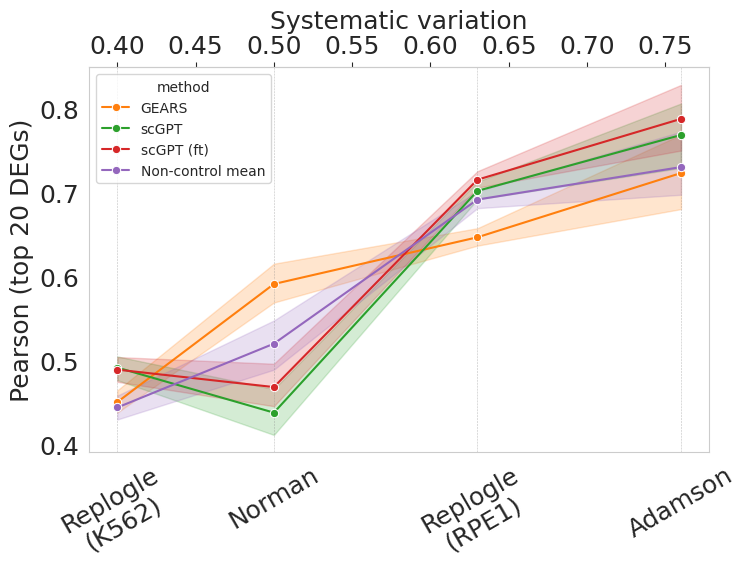

In [228]:
# Cosine similarity
metric = 'corr_20de'
fontsize=18

plt.figure(figsize=(8, 5))
plt.grid(False)
x = [0.4, 0.50, 0.63, 0.76]
methods = ['gears', 'scgpt', 'scgpt_ft', 'nonctl-mean']
labels=['GEARS', 'scGPT', 'scGPT (ft)', 'Non control mean']
datasets = ['ReplogleK562', 'Norman', 'ReplogleRPE1', 'Adamson']
x_labels = ['Replogle\n(K562)', 'Norman', 'Replogle\n(RPE1)', 'Adamson']
x = [0.4, 0.50, 0.63, 0.76]
x_dict = {d: xi for d, xi in zip(datasets, x)}
results_df_.loc[:, 'avg_cosim'] = results_df_['dataset'].map(x_dict)
results_df_2 = results_df_[~results_df_['method'].isin(['CPA','matching-mean'])]
palette = sns.color_palette("tab10")
sns.lineplot(x="avg_cosim", y=metric,
             hue="method", errorbar=('ci', 50), # style="event",
             data=results_df_2,
             marker='o',
             palette=palette[1:])
ax =  plt.gca()
secax = ax.secondary_xaxis("top")
secax.tick_params(axis='x', labelsize=fontsize)
secax.set_xlabel('Systematic variation', fontsize=fontsize)
# secax.set_xlabel('Average cosine similarity', fontsize=fontsize)
plt.yticks(fontsize=fontsize)
ax.set_xticks(x, x_labels, rotation=30, fontsize=fontsize)
for x_ in x:
    ax.axvline(x=x_, color='grey', linestyle='--', linewidth=0.4, alpha=0.5, zorder=1)
plt.xlabel('')
plt.ylabel('Pearson (top 20 DEGs)', fontsize=fontsize)
# plt.legend(loc='center right', bbox_to_anchor=(1.55, 0.5), fancybox=True, shadow=True, fontsize=fontsize)

labels=['GEARS', 'scGPT', 'scGPT (ft)', 'Non control mean']
for i, label in enumerate(labels):
    legend.get_texts()[i].set_text(label)
plt.savefig(f'{figdir}/{metric}_by_dataset_alignment_2.pdf', bbox_inches='tight');

In [240]:
x = [0.4, 0.50, 0.63, 0.76]
c = results_df_.groupby(['method', 'dataset'])['corr_all'].mean().loc['GEARS']
pearsonr(x, c.loc[datasets])

PearsonRResult(statistic=0.9774108800588527, pvalue=0.022589119941147207)

In [239]:
x = [0.4, 0.50, 0.63, 0.76]
c = results_df_.groupby(['method', 'dataset'])['corr_all'].mean().loc['scGPT (ft)']
pearsonr(x, c.loc[datasets])

PearsonRResult(statistic=0.9047459665653347, pvalue=0.09525403343466543)

/tmp/ipykernel_3006023/1496142274.py:17: UserWarning: The palette list has more values (9) than needed (4), which may not be intended.
  sns.lineplot(x="avg_cosim", y=metric,


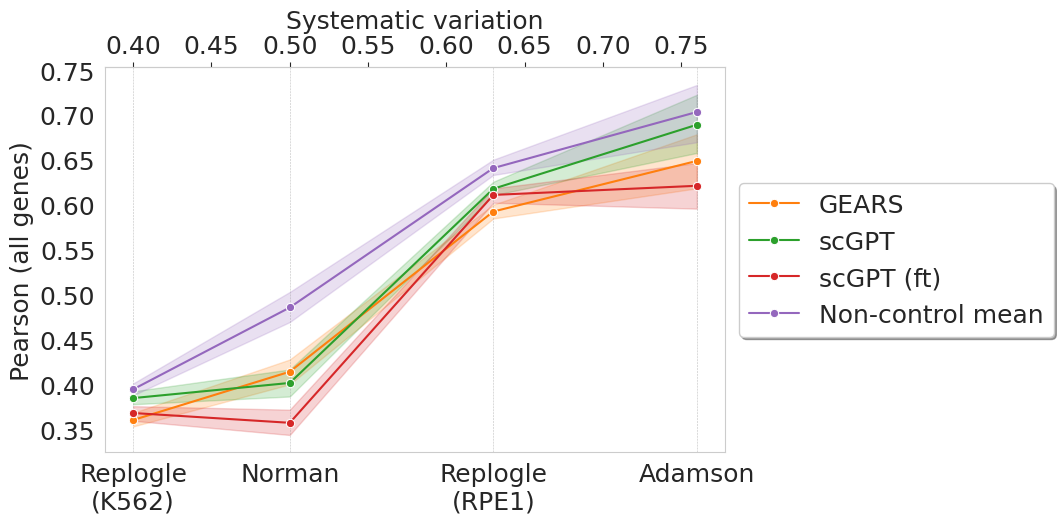

In [210]:
# Cosine similarity
metric = 'corr_all'
fontsize=18

plt.figure(figsize=(8, 5))
plt.grid(False)
x = [0.4, 0.50, 0.63, 0.76]
methods = ['gears', 'scgpt', 'scgpt_ft', 'nonctl-mean']
labels=['GEARS', 'scGPT', 'scGPT (ft)', 'Non control mean']
datasets = ['ReplogleK562', 'Norman', 'ReplogleRPE1', 'Adamson']
x_labels = ['Replogle\n(K562)', 'Norman', 'Replogle\n(RPE1)', 'Adamson']
x = [0.4, 0.50, 0.63, 0.76]
x_dict = {d: xi for d, xi in zip(datasets, x)}
results_df_.loc[:, 'avg_cosim'] = results_df_['dataset'].map(x_dict)
results_df_2 = results_df_[~results_df_['method'].isin(['CPA','matching-mean'])]
palette = sns.color_palette("tab10")
sns.lineplot(x="avg_cosim", y=metric,
             hue="method", errorbar=('ci', 50), # style="event",
             data=results_df_2,
             marker='o',
             palette=palette[1:])
ax =  plt.gca()
secax = ax.secondary_xaxis("top")
secax.tick_params(axis='x', labelsize=fontsize)
secax.set_xlabel('Systematic variation', fontsize=fontsize)
# secax.set_xlabel('Average cosine similarity', fontsize=fontsize)
plt.yticks(fontsize=fontsize)
ax.set_xticks(x, x_labels, rotation=0, fontsize=fontsize)
for x_ in x:
    ax.axvline(x=x_, color='grey', linestyle='--', linewidth=0.4, alpha=0.5, zorder=1)
plt.xlabel('')
plt.ylabel('Pearson (all genes)', fontsize=fontsize)
plt.legend(loc='center right', bbox_to_anchor=(1.55, 0.5), fancybox=True, shadow=True, fontsize=fontsize)

labels=['GEARS', 'scGPT', 'scGPT (ft)', 'Non control mean']
for i, label in enumerate(labels):
    legend.get_texts()[i].set_text(label)
plt.savefig(f'{figdir}/{metric}_by_dataset_alignment_2.pdf', bbox_inches='tight');

/tmp/ipykernel_3006023/2090693052.py:17: UserWarning: The palette list has more values (9) than needed (4), which may not be intended.
  sns.lineplot(x="avg_cosim", y=metric,


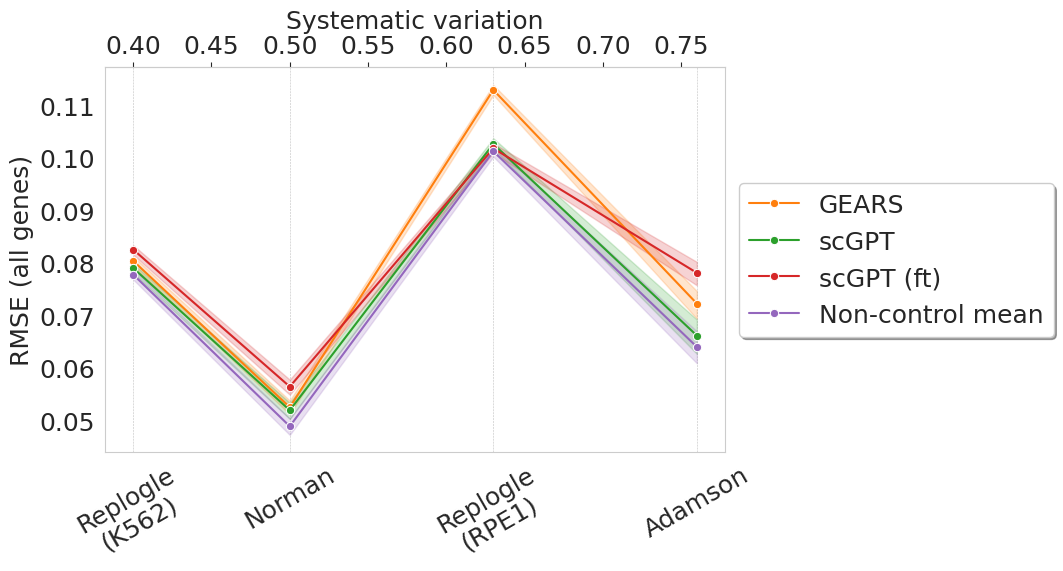

In [226]:
# Cosine similarity
metric = 'rmse_all'
fontsize=18

plt.figure(figsize=(8, 5))
plt.grid(False)
x = [0.4, 0.50, 0.63, 0.76]
methods = ['gears', 'scgpt', 'scgpt_ft', 'nonctl-mean']
labels=['GEARS', 'scGPT', 'scGPT (ft)', 'Non control mean']
datasets = ['ReplogleK562', 'Norman', 'ReplogleRPE1', 'Adamson']
x_labels = ['Replogle\n(K562)', 'Norman', 'Replogle\n(RPE1)', 'Adamson']
x = [0.4, 0.50, 0.63, 0.76]
x_dict = {d: xi for d, xi in zip(datasets, x)}
results_df_.loc[:, 'avg_cosim'] = results_df_['dataset'].map(x_dict)
results_df_2 = results_df_[~results_df_['method'].isin(['CPA','matching-mean'])]
palette = sns.color_palette("tab10")
sns.lineplot(x="avg_cosim", y=metric,
             hue="method", errorbar=('ci', 50), # style="event",
             data=results_df_2,
             marker='o',
             palette=palette[1:])
ax =  plt.gca()
secax = ax.secondary_xaxis("top")
secax.tick_params(axis='x', labelsize=fontsize)
secax.set_xlabel('Systematic variation', fontsize=fontsize)
# secax.set_xlabel('Average cosine similarity', fontsize=fontsize)
plt.yticks(fontsize=fontsize)
ax.set_xticks(x, x_labels, rotation=30, fontsize=fontsize)
for x_ in x:
    ax.axvline(x=x_, color='grey', linestyle='--', linewidth=0.4, alpha=0.5, zorder=1)
plt.xlabel('')
plt.ylabel('RMSE (all genes)', fontsize=fontsize)
plt.legend(loc='center right', bbox_to_anchor=(1.55, 0.5), fancybox=True, shadow=True, fontsize=fontsize)

labels=['GEARS', 'scGPT', 'scGPT (ft)', 'Non control mean']
for i, label in enumerate(labels):
    legend.get_texts()[i].set_text(label)
plt.savefig(f'{figdir}/{metric}_by_dataset_alignment_2.pdf', bbox_inches='tight');

/tmp/ipykernel_3006023/3988178310.py:17: UserWarning: The palette list has more values (9) than needed (4), which may not be intended.
  sns.lineplot(x="avg_cosim", y=metric,


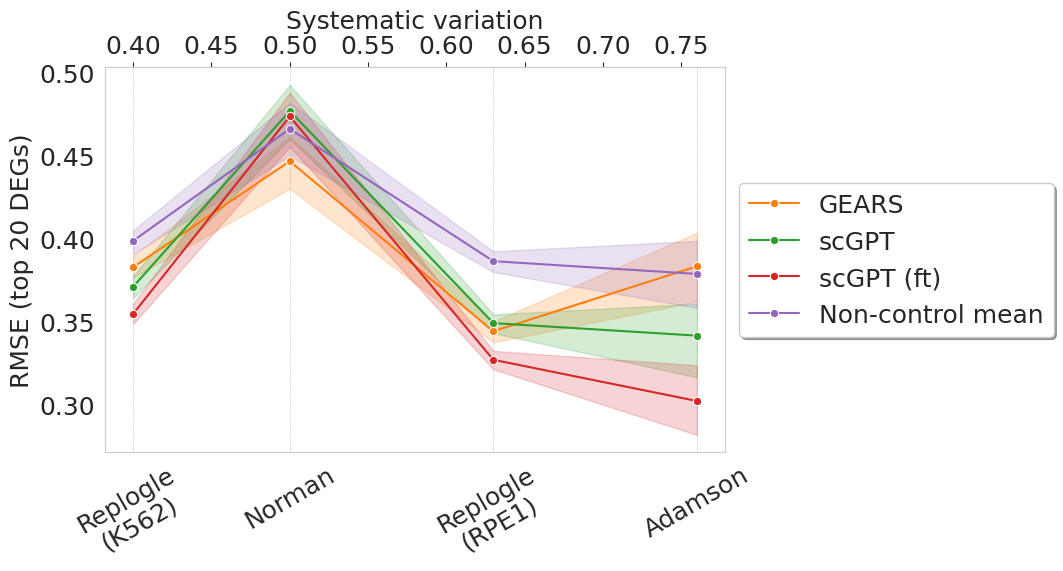

In [223]:
# Cosine similarity
metric = 'rmse_20de'
fontsize=18

plt.figure(figsize=(8, 5))
plt.grid(False)
x = [0.4, 0.50, 0.63, 0.76]
methods = ['gears', 'scgpt', 'scgpt_ft', 'nonctl-mean']
labels=['GEARS', 'scGPT', 'scGPT (ft)', 'Non control mean']
datasets = ['ReplogleK562', 'Norman', 'ReplogleRPE1', 'Adamson']
x_labels = ['Replogle\n(K562)', 'Norman', 'Replogle\n(RPE1)', 'Adamson']
x = [0.4, 0.50, 0.63, 0.76]
x_dict = {d: xi for d, xi in zip(datasets, x)}
results_df_.loc[:, 'avg_cosim'] = results_df_['dataset'].map(x_dict)
results_df_2 = results_df_[~results_df_['method'].isin(['CPA','matching-mean'])]
palette = sns.color_palette("tab10")
sns.lineplot(x="avg_cosim", y=metric,
             hue="method", errorbar=('ci', 50), # style="event",
             data=results_df_2,
             marker='o',
             palette=palette[1:])
ax =  plt.gca()
secax = ax.secondary_xaxis("top")
secax.tick_params(axis='x', labelsize=fontsize)
secax.set_xlabel('Systematic variation', fontsize=fontsize)
# secax.set_xlabel('Average cosine similarity', fontsize=fontsize)
plt.yticks(fontsize=fontsize)
ax.set_xticks(x, x_labels, rotation=30, fontsize=fontsize)
for x_ in x:
    ax.axvline(x=x_, color='grey', linestyle='--', linewidth=0.4, alpha=0.5, zorder=1)
plt.xlabel('')
plt.ylabel('RMSE (top 20 DEGs)', fontsize=fontsize)
plt.legend(loc='center right', bbox_to_anchor=(1.55, 0.5), fancybox=True, shadow=True, fontsize=fontsize)

labels=['GEARS', 'scGPT', 'scGPT (ft)', 'Non control mean']
for i, label in enumerate(labels):
    legend.get_texts()[i].set_text(label)
plt.savefig(f'{figdir}/{metric}_by_dataset_alignment_2.pdf', bbox_inches='tight');

/tmp/ipykernel_3006023/3834889182.py:15: UserWarning: The palette list has more values (9) than needed (4), which may not be intended.
  sns.lineplot(x="avg_cosim", y=metric,


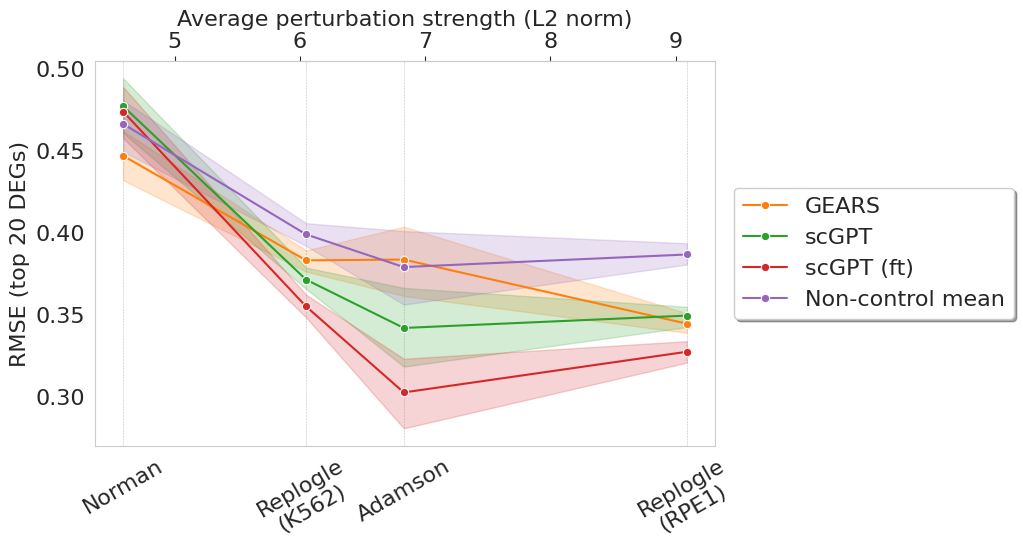

In [224]:
metric = 'rmse_20de'
fontsize=16

plt.figure(figsize=(8, 5))
plt.grid(False)
methods = ['gears', 'scgpt', 'scgpt_ft', 'nonctl-mean']
labels=['GEARS', 'scGPT', 'scGPT (ft)', 'Non control mean']
datasets = ['Norman','ReplogleK562', 'Adamson', 'ReplogleRPE1']
x_labels = ['Norman','Replogle\n(K562)', 'Adamson', 'Replogle\n(RPE1)']
x = [4.59, 6.05, 6.83, 9.09]
x_dict = {d: xi for d, xi in zip(datasets, x)}
results_df_.loc[:, 'avg_cosim'] = results_df_['dataset'].map(x_dict)
results_df_2 = results_df_[~results_df_['method'].isin(['CPA','matching-mean'])]
palette = sns.color_palette("tab10")
sns.lineplot(x="avg_cosim", y=metric,
             hue="method", errorbar=('ci', 50), # style="event",
             data=results_df_2,
             marker='o',
             palette=palette[1:])
ax =  plt.gca()
secax = ax.secondary_xaxis("top")
secax.tick_params(axis='x', labelsize=fontsize)
secax.set_xlabel('Average perturbation strength (L2 norm)', fontsize=fontsize)
plt.yticks(fontsize=fontsize)
ax.set_xticks(x, x_labels, rotation=30, fontsize=fontsize)
for x_ in x:
    ax.axvline(x=x_, color='grey', linestyle='--', linewidth=0.4, alpha=0.5, zorder=1)
plt.xlabel('')
plt.ylabel('RMSE (top 20 DEGs)', fontsize=fontsize)
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fancybox=True, shadow=True, fontsize=fontsize)

labels=['GEARS', 'scGPT', 'scGPT (ft)', 'Non control mean']
for i, label in enumerate(labels):
    legend.get_texts()[i].set_text(label)
plt.savefig(f'{figdir}/{metric}_by_perturbation-strength.pdf', bbox_inches='tight');

/tmp/ipykernel_3006023/3113741534.py:15: UserWarning: The palette list has more values (9) than needed (4), which may not be intended.
  sns.lineplot(x="avg_cosim", y=metric,


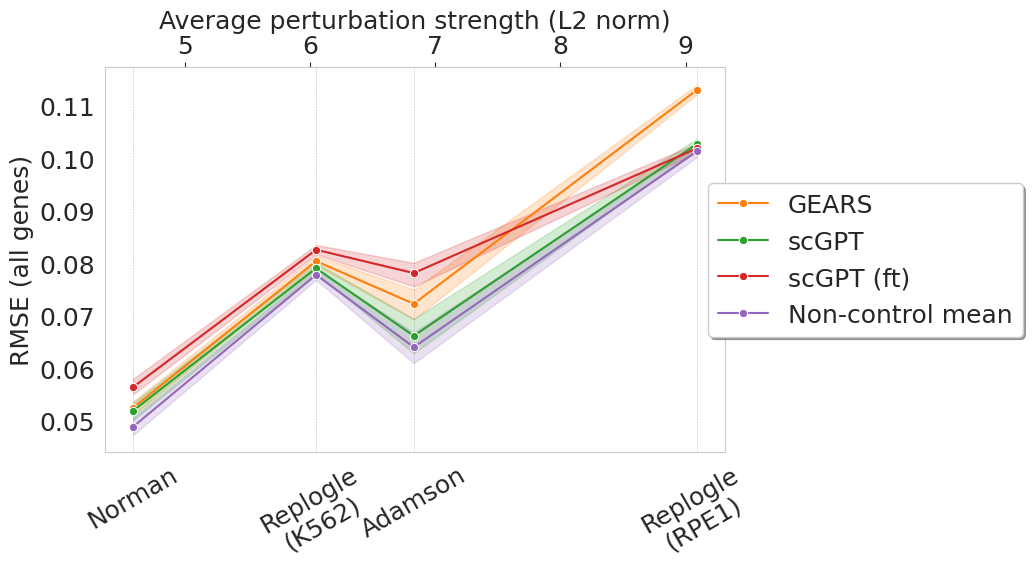

In [225]:
metric = 'rmse_all'
fontsize=18

plt.figure(figsize=(8, 5))
plt.grid(False)
methods = ['gears', 'scgpt', 'scgpt_ft', 'nonctl-mean']
labels=['GEARS', 'scGPT', 'scGPT (ft)', 'Non control mean']
datasets = ['Norman','ReplogleK562', 'Adamson', 'ReplogleRPE1']
x_labels = ['Norman','Replogle\n(K562)', 'Adamson', 'Replogle\n(RPE1)']
x = [4.59, 6.05, 6.83, 9.09]
x_dict = {d: xi for d, xi in zip(datasets, x)}
results_df_.loc[:, 'avg_cosim'] = results_df_['dataset'].map(x_dict)
results_df_2 = results_df_[~results_df_['method'].isin(['CPA','matching-mean'])]
palette = sns.color_palette("tab10")
sns.lineplot(x="avg_cosim", y=metric,
             hue="method", errorbar=('ci', 50), # style="event",
             data=results_df_2,
             marker='o',
             palette=palette[1:])
ax =  plt.gca()
secax = ax.secondary_xaxis("top")
secax.tick_params(axis='x', labelsize=fontsize)
secax.set_xlabel('Average perturbation strength (L2 norm)', fontsize=fontsize)
plt.yticks(fontsize=fontsize)
ax.set_xticks(x, x_labels, rotation=30, fontsize=fontsize)
for x_ in x:
    ax.axvline(x=x_, color='grey', linestyle='--', linewidth=0.4, alpha=0.5, zorder=1)
plt.xlabel('')
plt.ylabel('RMSE (all genes)', fontsize=fontsize)
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fancybox=True, shadow=True, fontsize=fontsize)

labels=['GEARS', 'scGPT', 'scGPT (ft)', 'Non control mean']
for i, label in enumerate(labels):
    legend.get_texts()[i].set_text(label)
plt.savefig(f'{figdir}/{metric}_by_perturbation-strength.pdf', bbox_inches='tight');

#### Dotplot figure

In [120]:
def custom_cmap(values, descending=True):
    mx = np.max(values)
    mn = np.min(values)
    if descending:
        mx = np.min(values)
        mn = np.max(values)
        
    def get_color(x):
        sign = 1 if int(descending) else -1
        idx = sign*2
        # print(np.partition(values, -2)[idx])
        x_sorted = np.sort(values)
        if descending:
            x_sorted = x_sorted[::-1]
        if np.allclose(x, mx):
            return "#46a64e"
        elif x == x_sorted[idx]: # np.partition(values, -2)[idx]:
            return "#c9ecb4"
        return "#ffffff"
    return get_color     

In [205]:
fontsize = 9
method_names = {
    'cpa': 'CPA',
    'gears': 'GEARS',
    'scgpt': 'scGPT',
    'scgpt_ft': 'scGPT (ft)',
    'nonctl-mean': 'Non-control mean',
    # 'matching-mean': 'Matching mean'
}

metric_names = {
    'corr_all': 'Pearson',
    'corr_20de': 'Pearson$_{20}$',
    # 'rmse_all': 'RMSE↓',
    # 'rmse_20de': 'RMSE$_{20}$↓',
    # 'jaccard': 'Jaccard$_{20}$↑'
}

# datasets_ = ['ReplogleK562', 'Adamson2016', 'Norman2019']
dataset_names = {
    'Adamson2016': 'Adamson',
    # 'Dixit2016': 'Dixit',
    'Norman2019': 'Norman',
    'ReplogleK562': 'ReplogleK562',
    'ReplogleRPE1': 'ReplogleRPE1',
}

results_df['method'] = results_df['method'].replace(method_names)
results_df['dataset'] = results_df['dataset'].replace(dataset_names)

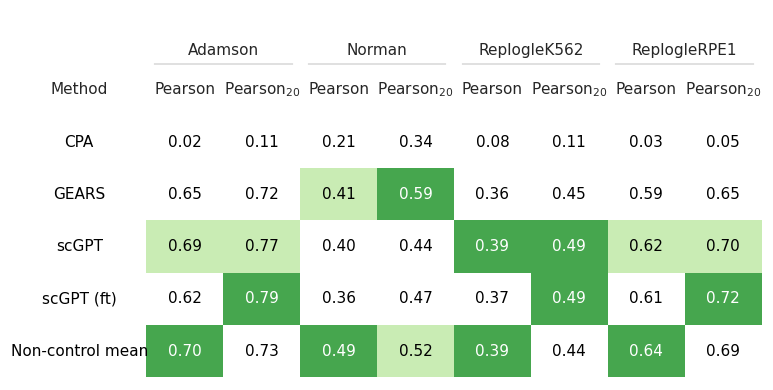

In [206]:
fontsize=11

results_df_ = results_df[results_df['one gene'] == '1-gene']
df = results_df_[['dataset', 'method'] + list(metric_names.keys())].groupby(['dataset', 'method']).mean()
df = df.round(2)
df_ = df.unstack(level=0).swaplevel(1, 0, axis=1).loc[method_names.values()]

col_defs = [
        ColumnDefinition(
            name="method",
            title="Method",
            textprops={"ha": "center", "fontsize": fontsize},  # "weight": "bold"
            width=1.75,
        ),
    ]

cmap = LinearSegmentedColormap.from_list(
    name="bugw", colors=["#ffffff", "#f2fbd2", "#c9ecb4", "#93d3ab", "#35b0ab"], N=256
)

cols_order = []
for d in dataset_names.values():
    for m, m_name in metric_names.items():
        cmap_name = matplotlib.cm.PiYG
        if '↓' in m_name:
            cmap_name = matplotlib.cm.PiYG_r
            print(m_name)
        
        col = (d, m)
        cols_order.append(col)
        col_def = ColumnDefinition(
            name=col,
            title=m_name,
            # formatter=decimal_to_percent,
            group=d,
            border="left",
            formatter="{:.2f}",
            width=1,
            # cmap=cmap,
            textprops={
                "ha": "center",
                # "bbox": {"boxstyle": "circle", "pad": 0.},
            },
            cmap = custom_cmap(df_[(d, m)], descending=m_name.endswith('↓'))
            # cmap=normed_cmap(df_[col], cmap=cmap_name, num_stds=2),
        )
        col_defs.append(col_def)
            

"""
textprops={
    "ha": "center",
    "bbox": {"boxstyle": "circle", "pad": 0.35},
},
"""

fig, ax = plt.subplots(figsize=(8, 4))

# letter_annotation(plt.gca(), 0, 0.9, 'a', fontsize=28)
table = Table(
    df_[cols_order],
    column_definitions=col_defs,
    row_dividers=False,
    col_label_divider=False,
    footer_divider=False,
    # even_row_color='whitesmoke',
    ax=ax,
    textprops={"fontsize": fontsize},
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 0, "linestyle": "-"},
).autoset_fontcolors()  # colnames=["OFF", "DEF"]
plt.tight_layout()
plt.savefig(f'{figdir}/benchmark_summary_table_pearson_all_2.pdf', bbox_inches='tight');
# plt.savefig(f'{figdir}/benchmark_summary_table_adamson_norman.pdf', bbox_inches='tight');

In [57]:
fontsize = 9
method_names = {
    'cpa': 'CPA',
    'gears': 'GEARS',
    'scgpt': 'scGPT',
    'scgpt_ft': 'scGPT (ft)',
    'nonctl-mean': 'Non-control mean',
    # 'matching-mean': 'Matching mean'
}

metric_names = {
    # 'corr_all': 'Pearson↑',
    # 'corr_20de': 'Pearson$_{20}$↑',
    'rmse_all': 'RMSE↓',
    'rmse_20de': 'RMSE$_{20}$↓',
    'jaccard': 'Jaccard$_{20}$↑'
}

# datasets_ = ['ReplogleK562', 'Adamson2016', 'Norman2019']
dataset_names = {
    'Adamson2016': 'Adamson',
    # 'Dixit2016': 'Dixit',
    'Norman2019': 'Norman',
    'ReplogleK562': 'ReplogleK562',
    'ReplogleRPE1': 'ReplogleRPE1',
}

results_df['method'] = results_df['method'].replace(method_names)
results_df['dataset'] = results_df['dataset'].replace(dataset_names)

RMSE↓
RMSE$_{20}$↓
RMSE↓
RMSE$_{20}$↓
RMSE↓
RMSE$_{20}$↓
RMSE↓
RMSE$_{20}$↓


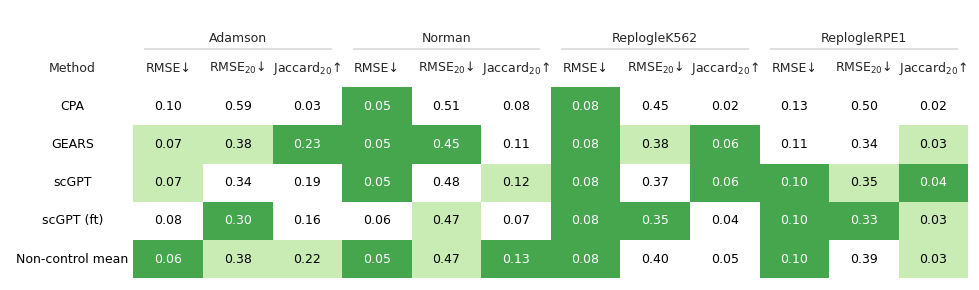

In [58]:
results_df_ = results_df[results_df['one gene'] == '1-gene']
df = results_df_[['dataset', 'method'] + list(metric_names.keys())].groupby(['dataset', 'method']).mean()
df = df.round(2)
df_ = df.unstack(level=0).swaplevel(1, 0, axis=1).loc[method_names.values()]

col_defs = [
        ColumnDefinition(
            name="method",
            title="Method",
            textprops={"ha": "center", "fontsize": fontsize},  # "weight": "bold"
            width=1.75,
        ),
    ]

cmap = LinearSegmentedColormap.from_list(
    name="bugw", colors=["#ffffff", "#f2fbd2", "#c9ecb4", "#93d3ab", "#35b0ab"], N=256
)

cols_order = []
for d in dataset_names.values():
    for m, m_name in metric_names.items():
        cmap_name = matplotlib.cm.PiYG
        if '↓' in m_name:
            cmap_name = matplotlib.cm.PiYG_r
            print(m_name)
        
        col = (d, m)
        cols_order.append(col)
        col_def = ColumnDefinition(
            name=col,
            title=m_name,
            # formatter=decimal_to_percent,
            group=d,
            border="left",
            formatter="{:.2f}",
            width=1,
            # cmap=cmap,
            textprops={
                "ha": "center",
                # "bbox": {"boxstyle": "circle", "pad": 0.},
            },
            cmap = custom_cmap(df_[(d, m)], descending=m_name.endswith('↓'))
            # cmap=normed_cmap(df_[col], cmap=cmap_name, num_stds=2),
        )
        col_defs.append(col_def)

fig, ax = plt.subplots(figsize=(10, 3))

# letter_annotation(plt.gca(), 0, 0.9, 'a', fontsize=28)
table = Table(
    df_[cols_order],
    column_definitions=col_defs,
    row_dividers=False,
    col_label_divider=False,
    footer_divider=False,
    # even_row_color='whitesmoke',
    ax=ax,
    textprops={"fontsize": fontsize},
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 0, "linestyle": "-"},
).autoset_fontcolors()  # colnames=["OFF", "DEF"]
plt.tight_layout()
plt.savefig(f'{figdir}/benchmark_summary_table_rmsejaccard_all.pdf', bbox_inches='tight');
# plt.savefig(f'{figdir}/benchmark_summary_table_adamson_norman.pdf', bbox_inches='tight');

#### Dotplot figure, pert centroid

In [63]:
fontsize = 9
method_names = {
    'cpa': 'CPA',
    'gears': 'GEARS',
    'scgpt': 'scGPT',
    'scgpt_ft': 'scGPT (ft)',
    'nonctl-mean': 'Non-control mean',
    # 'matching-mean': 'Matching mean'
}

metric_names = {
    'corr_all_allpert': 'Pearson↑',
    'corr_20de_allpert': 'Pearson$_{20}$↑',
     # 'rmse_all': 'RMSE↓',
     # 'rmse_20de': 'RMSE$_{20}$↓',
    'jaccard_allpert': 'Jaccard$_{20}$↑'
}

# datasets_ = ['ReplogleK562', 'Adamson2016', 'Norman2019']
dataset_names = {
    'Adamson2016': 'Adamson',
    # 'Dixit2016': 'Dixit',
    'Norman2019': 'Norman',
    'ReplogleK562': 'ReplogleK562',
    'ReplogleRPE1': 'ReplogleRPE1',
}

results_df['method'] = results_df['method'].replace(method_names)
results_df['dataset'] = results_df['dataset'].replace(dataset_names)

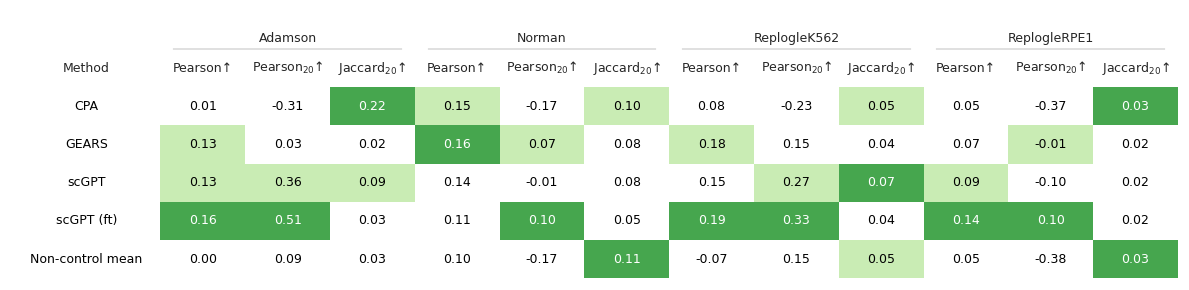

In [67]:
results_df_ = results_df[results_df['one gene'] == '1-gene']
df = results_df_[['dataset', 'method'] + list(metric_names.keys())].groupby(['dataset', 'method']).mean()
df = df.round(2)
df_ = df.unstack(level=0).swaplevel(1, 0, axis=1).loc[method_names.values()]

col_defs = [
        ColumnDefinition(
            name="method",
            title="Method",
            textprops={"ha": "center", "fontsize": fontsize},  # "weight": "bold"
            width=1.75,
        ),
    ]

cmap = LinearSegmentedColormap.from_list(
    name="bugw", colors=["#ffffff", "#f2fbd2", "#c9ecb4", "#93d3ab", "#35b0ab"], N=256
)

cols_order = []
for d in dataset_names.values():
    for m, m_name in metric_names.items():
        cmap_name = matplotlib.cm.PiYG
        if '↓' in m_name:
            cmap_name = matplotlib.cm.PiYG_r
            print(m_name)
        
        col = (d, m)
        cols_order.append(col)
        col_def = ColumnDefinition(
            name=col,
            title=m_name,
            # formatter=decimal_to_percent,
            group=d,
            border="left",
            formatter="{:.2f}",
            width=1,
            # cmap=cmap,
            textprops={
                "ha": "center",
                # "bbox": {"boxstyle": "circle", "pad": 0.},
            },
            cmap = custom_cmap(df_[(d, m)], descending=m_name.endswith('↓'))
            # cmap=normed_cmap(df_[col], cmap=cmap_name, num_stds=2),
        )
        col_defs.append(col_def)
            

"""
textprops={
    "ha": "center",
    "bbox": {"boxstyle": "circle", "pad": 0.35},
},
"""

fig, ax = plt.subplots(figsize=(12, 3))

# letter_annotation(plt.gca(), 0, 0.9, 'a', fontsize=28)
table = Table(
    df_[cols_order],
    column_definitions=col_defs,
    row_dividers=False,
    col_label_divider=False,
    footer_divider=False,
    # even_row_color='whitesmoke',
    ax=ax,
    textprops={"fontsize": fontsize},
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 0, "linestyle": "-"},
).autoset_fontcolors()  # colnames=["OFF", "DEF"]
plt.tight_layout()
# plt.savefig(f'{figdir}/benchmark_summary_table.pdf', bbox_inches='tight');
plt.savefig(f'{figdir}/benchmark_summary_table_all_pertcentroid.pdf', bbox_inches='tight');

In [34]:
df_ = results_df[results_df['dataset'] == 'Norman']
df_ = df_[df_['one gene'] == '1-gene']
df_[df_['method'] == 'CPA']

dataset method          pert  seed  corr_all  corr_20de  \
378   Norman    CPA     ctrl+PRTG     1  0.285728   0.834513   
379   Norman    CPA    ctrl+CEBPB     1 -0.085036  -0.597240   
380   Norman    CPA    FOXL2+ctrl     1 -0.140066  -0.392309   
386   Norman    CPA   CDKN1A+ctrl     1  0.086159   0.343779   
391   Norman    CPA   ctrl+COL2A1     1 -0.217003  -0.458879   
...      ...    ...           ...   ...       ...        ...   
1822  Norman    CPA   ARRDC3+ctrl     3  0.386252   0.725751   
1823  Norman    CPA      SET+ctrl     3  0.289332   0.698603   
1825  Norman    CPA   MAP4K3+ctrl     3  0.485719   0.868430   
1828  Norman    CPA  UBASH3B+ctrl     3  0.607747   0.888908   
1830  Norman    CPA      NCL+ctrl     3  0.246910   0.087123   

      corr_all_allpert  corr_20de_allpert   mse_all  mse_20de  \
378          -0.026482          -0.592166  0.003363  0.393248   
379          -0.338543          -0.459582  0.009345  0.656898   
380          -0.042920          -0.066710  0.002628  0.178753   
386          -0.203362          -0.747949  0.003207  0.273712   
391           0.070295          -0.235344  0.005454  0.612499   
...                ...                ...       ...       ...   
1822          0.637670           0.381623  0.000561  0.020076   
1823          0.179013          -0.131649  0.004509  0.376901   
1825          0.716587           0.697229  0.000429  0.007000   
1828          0.636198           0.321506  0.000703  0.050897   
1830          0.638801           0.782019  0.000731  0.034716   

      mse_all_allpert  mse_20de_allpert   jaccard  jaccard_allpert one gene  \
378          0.003363          0.393248  0.081081         0.052632   1-gene   
379          0.009345          0.656898  0.052632         0.081081   1-gene   
380          0.002628          0.178753  0.052632         0.142857   1-gene   
386          0.003207          0.273712  0.142857         0.212121   1-gene   
391          0.005454          0.612499  0.052632         0.052632   1-gene   
...               ...               ...       ...              ...      ...   
1822         0.000561          0.020076  0.081081         0.250000   1-gene   
1823         0.004509          0.376901  0.025641         0.025641   1-gene   
1825         0.000429          0.007000  0.176471         0.052632   1-gene   
1828         0.000703          0.050897  0.176471         0.025641   1-gene   
1830         0.000731          0.034716  0.025641         0.025641   1-gene   

      train  rmse_all  rmse_20de  rmse_all_allpert  rmse_20de_allpert  
378       0  0.057990   0.627095          0.057990           0.627095  
379       0  0.096668   0.810492          0.096668           0.810492  
380       0  0.051268   0.422792          0.051268           0.422792  
386       0  0.056630   0.523175          0.056630           0.523175  
391       0  0.073850   0.782623          0.073850           0.782623  
...     ...       ...        ...               ...                ...  
1822      0  0.023694   0.141691          0.023694           0.141691  
1823      0  0.067152   0.613923          0.067152           0.613923  
1825      0  0.020718   0.083666          0.020718           0.083666  
1828      0  0.026521   0.225603          0.026521           0.225603  
1830      0  0.027044   0.186324          0.027044           0.186324  

[108 rows x 20 columns]

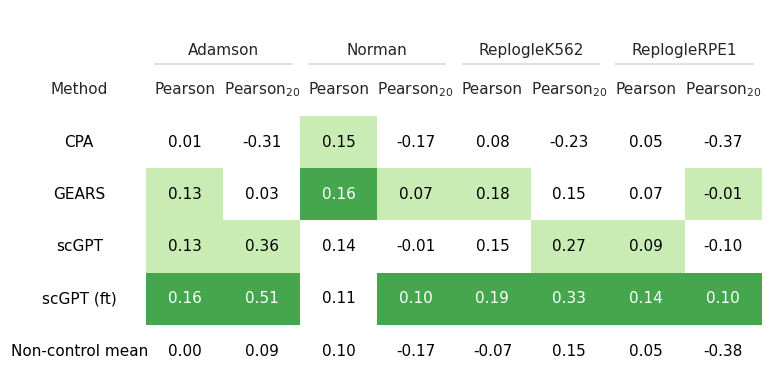

In [196]:
fontsize=11
method_names = {
    'cpa': 'CPA',
    'gears': 'GEARS',
    'scgpt': 'scGPT',
    'scgpt_ft': 'scGPT (ft)',
    'nonctl-mean': 'Non-control mean',
    # 'matching-mean': 'Matching mean'
}

metric_names = {
    'corr_all_allpert': 'Pearson',
    'corr_20de_allpert': 'Pearson$_{20}$',
    # 'rmse_all': 'RMSE↓',
    # 'rmse_20de': 'RMSE$_{20}$↓',
    # 'jaccard': 'Jaccard$_{20}$↑'
}

# datasets_ = ['ReplogleK562', 'Adamson2016', 'Norman2019']
dataset_names = {
    'Adamson2016': 'Adamson',
    # 'Dixit2016': 'Dixit',
    'Norman2019': 'Norman',
    'ReplogleK562': 'ReplogleK562',
    'ReplogleRPE1': 'ReplogleRPE1',
}

results_df['method'] = results_df['method'].replace(method_names)
results_df['dataset'] = results_df['dataset'].replace(dataset_names)

results_df_ = results_df[results_df['one gene'] == '1-gene']
df = results_df_[['dataset', 'method'] + list(metric_names.keys())].groupby(['dataset', 'method']).mean()
df = df.round(2)
df_ = df.unstack(level=0).swaplevel(1, 0, axis=1).loc[method_names.values()]

col_defs = [
        ColumnDefinition(
            name="method",
            title="Method",
            textprops={"ha": "center", "fontsize": fontsize},  # "weight": "bold"
            width=1.75,
        ),
    ]

cmap = LinearSegmentedColormap.from_list(
    name="bugw", colors=["#ffffff", "#f2fbd2", "#c9ecb4", "#93d3ab", "#35b0ab"], N=256
)

cols_order = []
for d in dataset_names.values():
    for m, m_name in metric_names.items():
        cmap_name = matplotlib.cm.PiYG
        if '↓' in m_name:
            cmap_name = matplotlib.cm.PiYG_r
            print(m_name)
        
        col = (d, m)
        cols_order.append(col)
        col_def = ColumnDefinition(
            name=col,
            title=m_name,
            # formatter=decimal_to_percent,
            group=d,
            border="left",
            formatter="{:.2f}",
            width=1,
            # cmap=cmap,
            textprops={
                "ha": "center",
                # "bbox": {"boxstyle": "circle", "pad": 0.},
            },
            cmap = custom_cmap(df_[(d, m)], descending=m_name.endswith('↓'))
            # cmap=normed_cmap(df_[col], cmap=cmap_name, num_stds=2),
        )
        col_defs.append(col_def)
            

"""
textprops={
    "ha": "center",
    "bbox": {"boxstyle": "circle", "pad": 0.35},
},
"""

fig, ax = plt.subplots(figsize=(8, 4))

# letter_annotation(plt.gca(), 0, 0.9, 'a', fontsize=28)
table = Table(
    df_[cols_order],
    column_definitions=col_defs,
    row_dividers=False,
    col_label_divider=False,
    footer_divider=False,
    # even_row_color='whitesmoke',
    ax=ax,
    textprops={"fontsize": fontsize},
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 0, "linestyle": "-"},
).autoset_fontcolors()  # colnames=["OFF", "DEF"]
plt.tight_layout()
plt.savefig(f'{figdir}/benchmark_summary_table_pearson_all_allpert.pdf', bbox_inches='tight');
# plt.savefig(f'{figdir}/benchmark_summary_table_adamson_norman.pdf', bbox_inches='tight');

#### Dotplot figure

In [242]:
fontsize = 19
method_names = {
    'cpa': 'CPA',
    'gears': 'GEARS',
    'scgpt': 'scGPT',
    'scgpt_ft': 'scGPT (ft)',
    'nonctl-mean': 'Non control mean',
    'matching-mean': 'Matching mean'
}

metric_names = {
    'corr_all': 'Pearson↑',
    'corr_20de': 'Pearson$_{20}$↑',
    'rmse_all': 'RMSE↓',
    'rmse_20de': 'RMSE$_{20}$↓',
    'jaccard': 'Jaccard$_{20}$↑'
}

# datasets_ = ['ReplogleK562', 'Adamson2016', 'Norman2019']
dataset_names = {
    # 'ReplogleK562': 'ReplogleK562',
    'Adamson2016': 'Adamson',
    'Dixit2016': 'Dixit',
    'Norman2019': 'Norman'
}

results_df['method'] = results_df['method'].replace(method_names)
results_df['dataset'] = results_df['dataset'].replace(dataset_names)

df = results_df[['dataset', 'method'] + list(metric_names.keys())].groupby(['dataset', 'method']).mean()
df = df.round(2)
df_ = df.unstack(level=0).swaplevel(1, 0, axis=1).loc[method_names.values()]

col_defs = [
        ColumnDefinition(
            name="method",
            title="Method",
            textprops={"ha": "center", "fontsize": fontsize},  # "weight": "bold"
            width=1.75,
        ),
    ]

cmap = LinearSegmentedColormap.from_list(
    name="bugw", colors=["#ffffff", "#f2fbd2", "#c9ecb4", "#93d3ab", "#35b0ab"], N=256
)

cols_order = []
for d in dataset_names.values():
    for m, m_name in metric_names.items():
        cmap_name = matplotlib.cm.PiYG
        if '↓' in m_name:
            cmap_name = matplotlib.cm.PiYG_r
            print(m_name)
            
        col = (d, m)
        cols_order.append(col)
        col_def = ColumnDefinition(
            name=col,
            title=m_name,
            # formatter=decimal_to_percent,
            group=d,
            border="left",
            textprops={
                "ha": "center",
                "bbox": {"boxstyle": "circle", "pad": 0.35},
            },
            formatter="{:.2f}",
            width=1,
            # cmap=cmap
            cmap=normed_cmap(df_[col], cmap=cmap_name, num_stds=2),
        )
        col_defs.append(col_def)

RMSE↓
RMSE$_{20}$↓
RMSE↓
RMSE$_{20}$↓
RMSE↓
RMSE$_{20}$↓


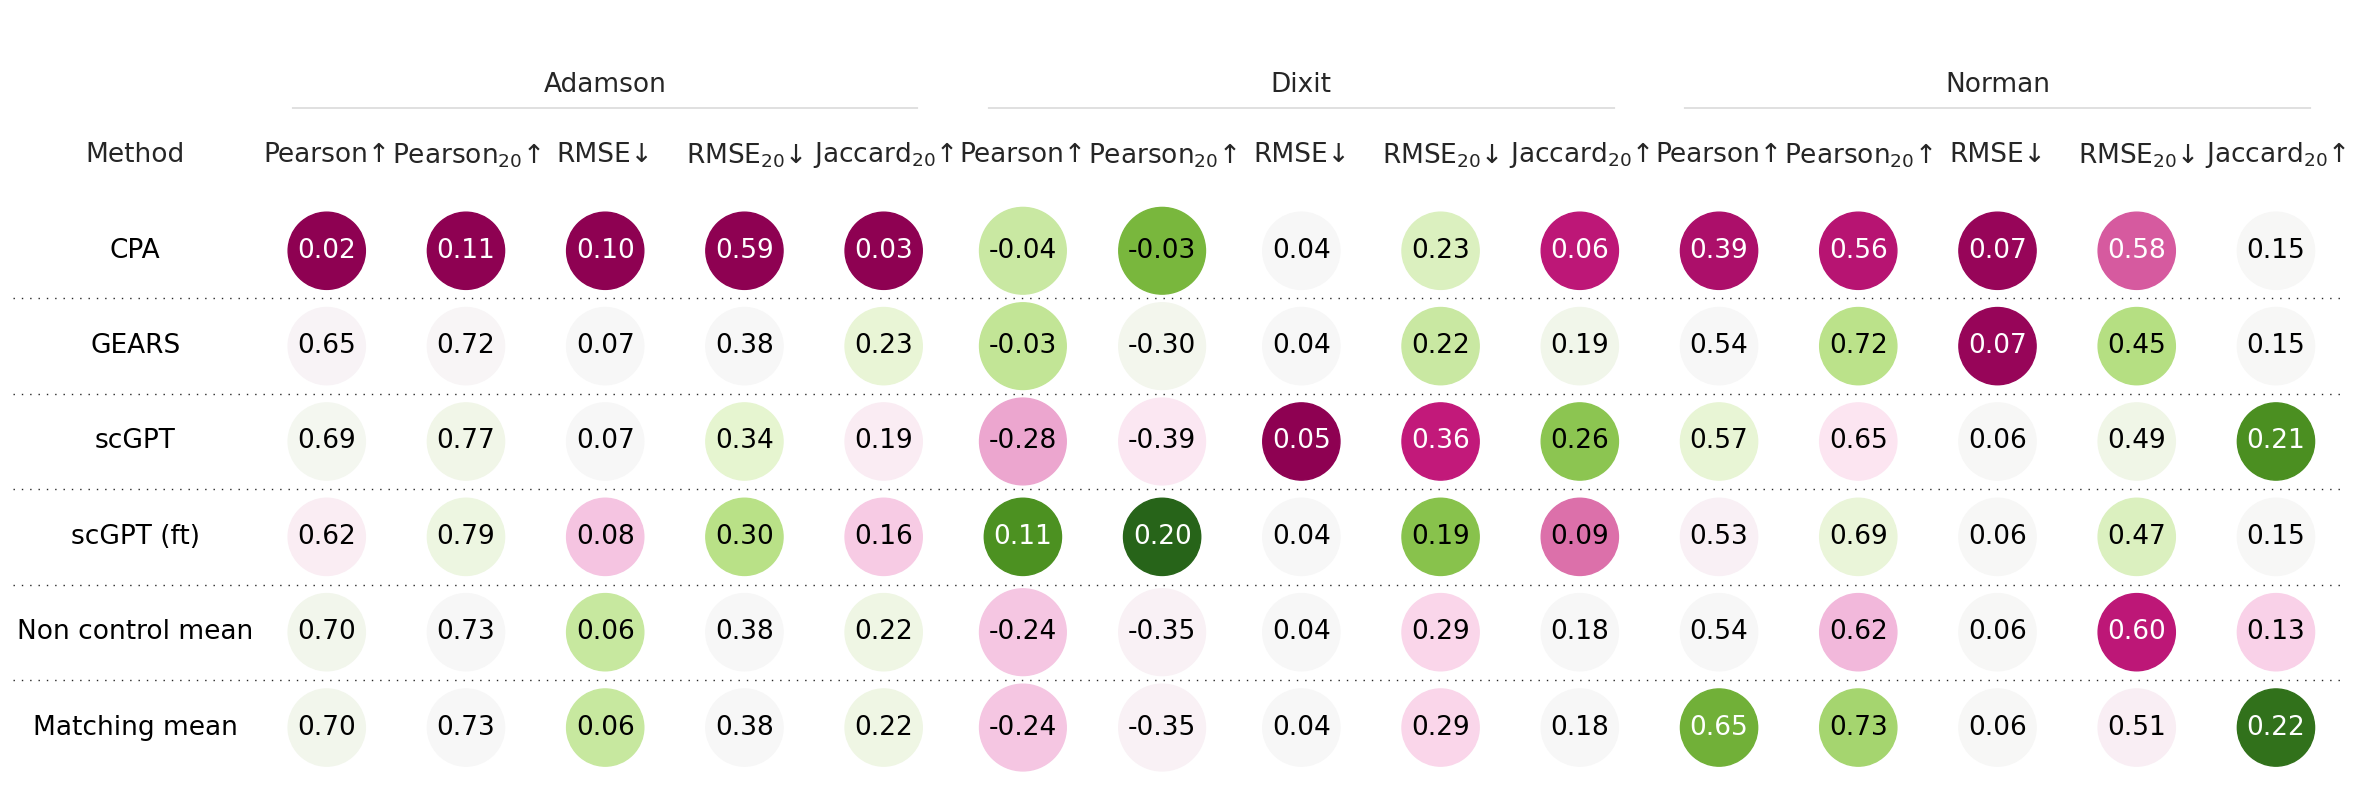

In [244]:
fig, ax = plt.subplots(figsize=(24, 8))

# letter_annotation(plt.gca(), 0, 0.9, 'a', fontsize=28)
table = Table(
    df_[cols_order],
    column_definitions=col_defs,
    row_dividers=True,
    col_label_divider=False,
    footer_divider=False,
    # even_row_color='whitesmoke',
    ax=ax,
    textprops={"fontsize": fontsize},
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 0, "linestyle": "-"},
).autoset_fontcolors()  # colnames=["OFF", "DEF"]
plt.tight_layout()
plt.savefig(f'{figdir}/benchmark_summary_table.pdf', bbox_inches='tight');
# plt.savefig(f'{figdir}/benchmark_summary_table_adamson_norman.pdf', bbox_inches='tight');

#### Dotplot figure (all pert reference)

In [245]:
fontsize = 19
method_names = {
    'cpa': 'CPA',
    'gears': 'GEARS',
    'scgpt': 'scGPT',
    'scgpt_ft': 'scGPT (ft)',
    'nonctl-mean': 'Non control mean',
    'matching-mean': 'Matching mean'
}

metric_names = {
    'corr_all_allpert': 'Pearson↑',
    'corr_20de_allpert': 'Pearson$_{20}$↑',
    'rmse_all_allpert': 'RMSE↓',
    'rmse_20de_allpert': 'RMSE$_{20}$↓',
    'jaccard_allpert': 'Jaccard$_{20}$↑'
}

# datasets_ = ['ReplogleK562', 'Adamson2016', 'Norman2019']
dataset_names = {
    # 'ReplogleK562': 'ReplogleK562',
    'Adamson2016': 'Adamson',
    'Dixit2016': 'Dixit',
    'Norman2019': 'Norman'
}

results_df['method'] = results_df['method'].replace(method_names)
results_df['dataset'] = results_df['dataset'].replace(dataset_names)

df = results_df[['dataset', 'method'] + list(metric_names.keys())].groupby(['dataset', 'method']).mean()
df = df.round(2)
df_ = df.unstack(level=0).swaplevel(1, 0, axis=1).loc[method_names.values()]

col_defs = [
        ColumnDefinition(
            name="method",
            title="Method",
            textprops={"ha": "center", "fontsize": fontsize},  # "weight": "bold"
            width=1.75,
        ),
    ]

cmap = LinearSegmentedColormap.from_list(
    name="bugw", colors=["#ffffff", "#f2fbd2", "#c9ecb4", "#93d3ab", "#35b0ab"], N=256
)

cols_order = []
for d in dataset_names.values():
    for m, m_name in metric_names.items():
        cmap_name = matplotlib.cm.PiYG
        if '↓' in m_name:
            cmap_name = matplotlib.cm.PiYG_r
            print(m_name)
            
        col = (d, m)
        cols_order.append(col)
        col_def = ColumnDefinition(
            name=col,
            title=m_name,
            # formatter=decimal_to_percent,
            group=d,
            border="left",
            textprops={
                "ha": "center",
                "bbox": {"boxstyle": "circle", "pad": 0.35},
            },
            formatter="{:.2f}",
            width=1,
            # cmap=cmap
            cmap=normed_cmap(df_[col], cmap=cmap_name, num_stds=2),
        )
        col_defs.append(col_def)

RMSE↓
RMSE$_{20}$↓
RMSE↓
RMSE$_{20}$↓
RMSE↓
RMSE$_{20}$↓


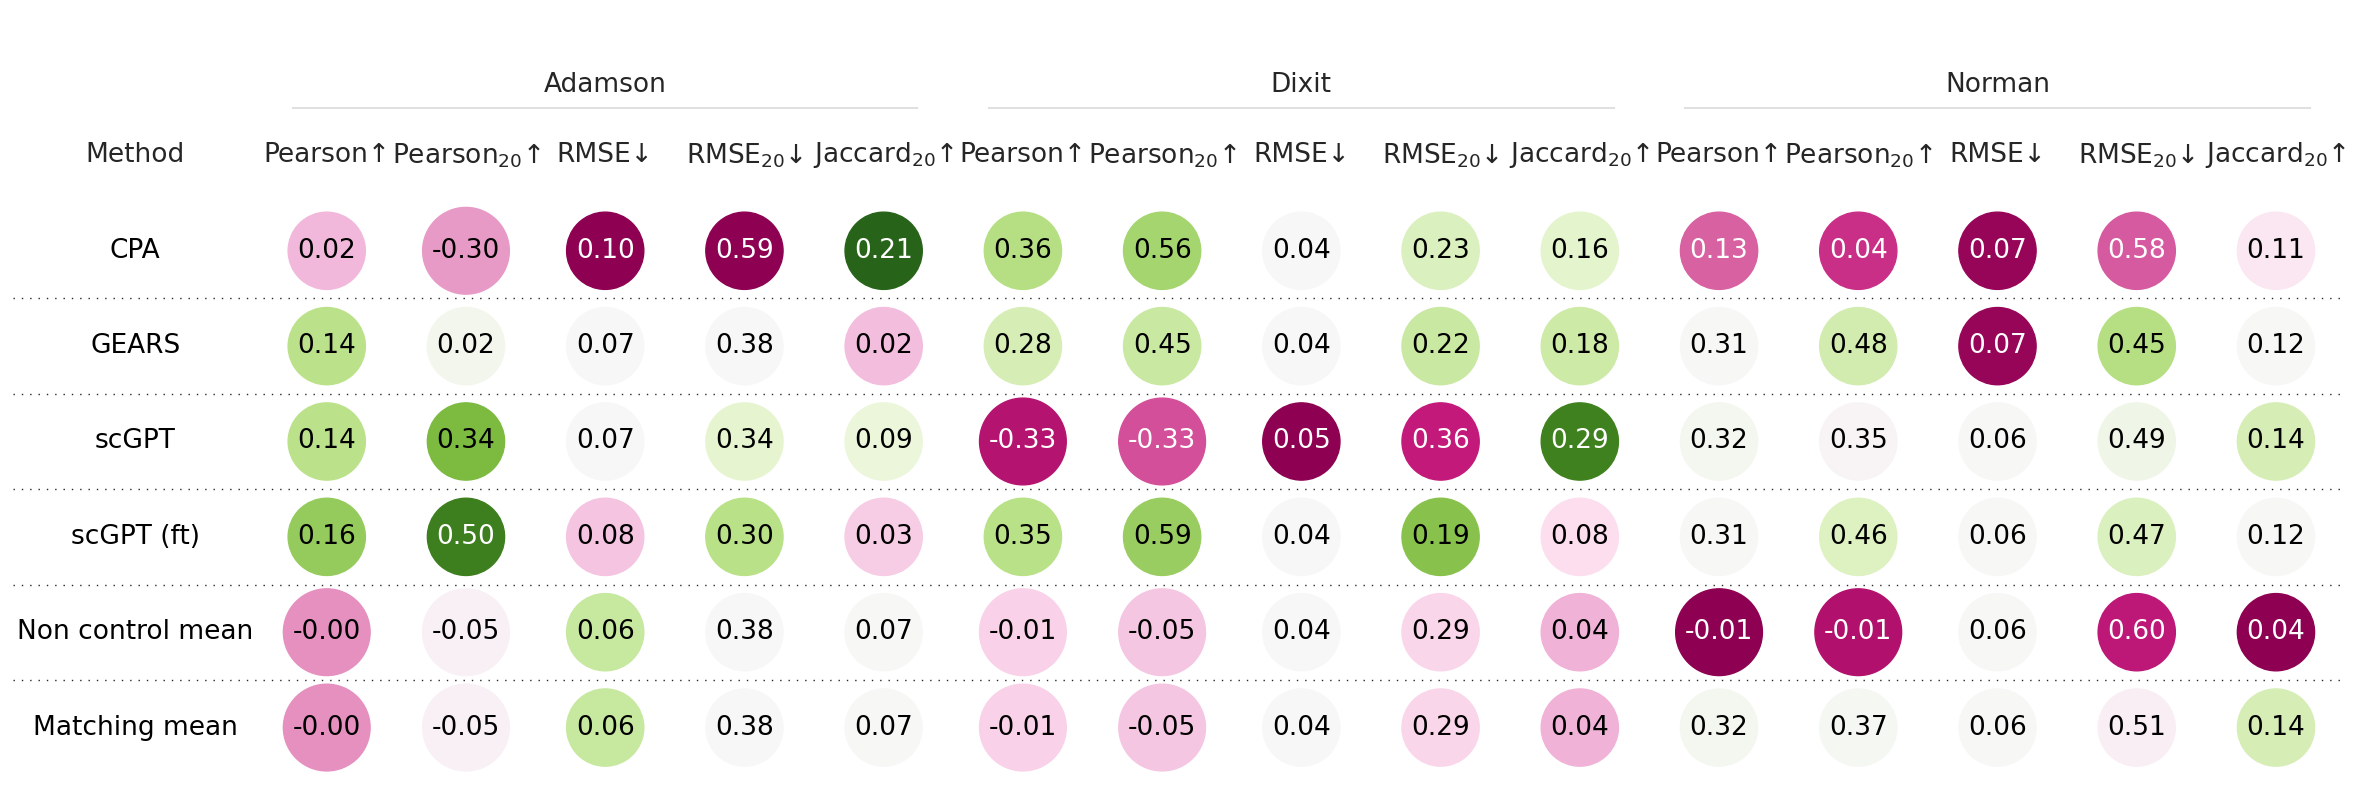

In [246]:
fig, ax = plt.subplots(figsize=(24, 8))

# letter_annotation(plt.gca(), 0, 0.9, 'a', fontsize=28)
table = Table(
    df_[cols_order],
    column_definitions=col_defs,
    row_dividers=True,
    col_label_divider=False,
    footer_divider=False,
    # even_row_color='whitesmoke',
    ax=ax,
    textprops={"fontsize": fontsize},
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 0, "linestyle": "-"},
).autoset_fontcolors()  # colnames=["OFF", "DEF"]
plt.tight_layout()
plt.savefig(f'{figdir}/benchmark_summary_table_allpert.pdf', bbox_inches='tight');
# plt.savefig(f'{figdir}/benchmark_summary_table_adamson_norman.pdf', bbox_inches='tight');

#### In-text results

In [85]:
df = results_df[(results_df['dataset'] == 'Norman') & (results_df['one gene'] == '1-gene')] # results_df[results_df['one gene'] == '1-gene']
n = len(df)
groupby = df.groupby('method')[['corr_all_allpert', 'corr_20de_allpert']]
groupby.mean(), groupby.std(), groupby.std() / np.sqrt(n), groupby.count()

(                  corr_all_allpert  corr_20de_allpert
 method                                               
 CPA                       0.090769          -0.198722
 GEARS                     0.142737           0.119356
 Matching mean            -0.009452          -0.012585
 Non control mean         -0.009452          -0.012585
 scGPT                     0.110928           0.026183
 scGPT (ft)                0.094602           0.143116,
                   corr_all_allpert  corr_20de_allpert
 method                                               
 CPA                       0.353998           0.477216
 GEARS                     0.253500           0.531146
 Matching mean             0.054567           0.227457
 Non control mean          0.054567           0.227457
 scGPT                     0.222247           0.416880
 scGPT (ft)                0.164314           0.369270,
                   corr_all_allpert  corr_20de_allpert
 method                                               
 CPA    

In [248]:
df = results_df[(results_df['dataset'] == 'Adamson') & (results_df['one gene'] == '1-gene')] # results_df[results_df['one gene'] == '1-gene']
n = len(df)
groupby = df.groupby('method')[['corr_all', 'corr_20de']]
groupby.mean(), groupby.std(), groupby.std() / np.sqrt(n), groupby.count()

(                  corr_all  corr_20de
 method                               
 CPA               0.023591   0.114507
 GEARS             0.649049   0.723018
 Matching mean     0.703510   0.730102
 Non control mean  0.703510   0.730102
 scGPT             0.689321   0.768228
 scGPT (ft)        0.621353   0.787367,
                   corr_all  corr_20de
 method                               
 CPA               0.180943   0.619433
 GEARS             0.342716   0.494916
 Matching mean     0.358913   0.471824
 Non control mean  0.358913   0.471824
 scGPT             0.366723   0.441200
 scGPT (ft)        0.294558   0.455028,
                   corr_all  corr_20de
 method                               
 CPA               0.009307   0.031860
 GEARS             0.017627   0.025456
 Matching mean     0.018460   0.024268
 Non control mean  0.018460   0.024268
 scGPT             0.018862   0.022693
 scGPT (ft)        0.015150   0.023404,
                   corr_all  corr_20de
 method               

#### Download results

In [42]:
import base64
import pandas as pd
from IPython.display import HTML

def create_download_link( df, title = "Download CSV file", filename = "data.csv"):
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)


In [43]:
create_download_link(results_df)